# Entrenamiento de la tecnología NPK CISNA para la detección del estado de salud en cultivos mediante modelos computacionales
**Análisis previo, preparación de datos** y **Entrenamiento**.

## 1) Análisis previo y preparación de datos


### 1.1) Cargar datos

In [30]:
#cargar datset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from scipy import stats
# Cargar el dataset combinado desde el archivo Excel
df_combinado_excel = pd.read_excel('/content/dataset_combinado.xlsx')

In [4]:
# Verificar datos nulos
df=df_combinado
df_combinado.isnull().sum()


,0
x_pixel,0
y_pixel,0
IDW_N,0
IDW_P,0
IDW_K,0
NDVI,0
Latitud,0
Longitud,0
lat_norm,0
lon_norm,0


###1.2 ) Limpieza general de datos

In [ ]:

# Inspección inicial del dataset
tipos= df.dtypes
print("los tipos de variable son", tipos)
valores_nulos= df.isnull().sum()
print("La cantidad de valores nulos es:",valores_nulos)
valores_duplicados= df.duplicated().sum()
print("La cantidad de valores duplicados es:",valores_duplicados)
#Se hace limpieza basica de datos, pero en este caso no aplica

los tipos de variable son x_pixel             float64
y_pixel             float64
IDW_N               float64
IDW_P               float64
IDW_K               float64
NDVI                float64
Latitud             float64
Longitud            float64
lat_norm            float64
lon_norm            float64
Distancia_norm      float64
Distancia_metros    float64
dtype: object
La cantidad de valores nulos es: x_pixel             0
y_pixel             0
IDW_N               0
IDW_P               0
IDW_K               0
NDVI                0
Latitud             0
Longitud            0
lat_norm            0
lon_norm            0
Distancia_norm      0
Distancia_metros    0
dtype: int64
La cantidad de valores duplicados es: 0


### 1.3) Estadisticas generales de los datos


In [ ]:
# Estadísticas generales del dataset
print(df[['IDW_N','IDW_P','IDW_K','NDVI','Distancia_norm']].describe())

               IDW_N          IDW_P          IDW_K           NDVI  \
count  301374.000000  301374.000000  301374.000000  301374.000000   
mean       61.122189      21.619728      30.462156       0.205933   
std        33.554987      11.953477      16.830379       0.177223   
min         7.002774       2.001027       3.001438      -0.664995   
25%        27.745995       9.674920      13.722084       0.076535   
50%        56.450887      20.181482      28.214444       0.210948   
75%        93.565630      33.169500      46.717190       0.337422   
max       119.997126      42.998941      59.998561       0.689096   

       Distancia_norm  
count   301374.000000  
mean         0.243756  
std          0.159024  
min          0.000000  
25%          0.124289  
50%          0.206533  
75%          0.330943  
max          1.000000  


### 1.4) Histograma del conjunto de datos original
 Exploran la forma de las distribuciones y posibles sesgos

array([[<Axes: title={'center': 'IDW_N'}>,
        <Axes: title={'center': 'IDW_P'}>],
       [<Axes: title={'center': 'IDW_K'}>,
        <Axes: title={'center': 'NDVI'}>],
       [<Axes: title={'center': 'Distancia_norm'}>, <Axes: >]],
      dtype=object)

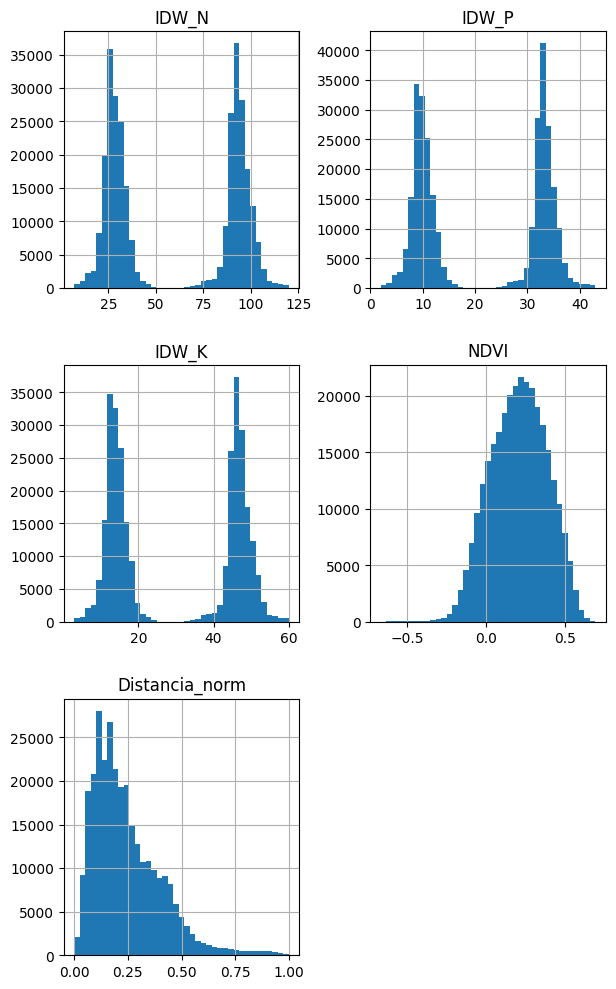

In [ ]:
#Histograma del dataset original
df[['IDW_N','IDW_P','IDW_K','NDVI','Distancia_norm']].hist(bins=39, figsize=(7,12))

### 1.5 Prueba de normalidad de Kolmogorov–Smirnov
Contrasta la distribución empírica de cada variable con una distribución teórica en este caso la normal.

In [26]:
from scipy.stats import kstest
import numpy as np

# Detecta los saltos para las graficas con dos modas
def split_by_gap(data, gap_threshold=None):
    sorted_data = np.sort(data)
    diffs = np.diff(sorted_data)

    if gap_threshold is None:

        gap_threshold = 5 * np.median(diffs)

    gap_index = np.where(diffs > gap_threshold)[0]
    if len(gap_index) == 0:
        return [data]
    cut = gap_index[np.argmax(diffs[gap_index])]
    group1 = sorted_data[:cut+1]
    group2 = sorted_data[cut+1:]
    return [group1, group2]


# Prueba de Normalidad de Kolmogorov-Smirnov

print("\nPrueba de Normalidad de Kolmogorov-Smirnov ")

# Variables bimodales
bimodal_vars = ['IDW_N', 'IDW_P', 'IDW_K']
# Variables unimodales
unimodal_vars = ['NDVI', 'Distancia_norm']

for var in bimodal_vars:
    data = df[var].dropna().values
    print(f"\nVariable Bimodal: {var}")
    groups = split_by_gap(data)

    for i, group in enumerate(groups, 1):
        if len(group) > 50:
            ks_statistic, p_value = kstest(group, 'norm', args=(np.mean(group), np.std(group)))
            print(f"  Grupo {i}:")
            print(f"    KS Statistic: {ks_statistic:.4f}, P-value: {p_value:.4f}")
            alpha = 0.05
            if p_value < alpha:
                print("    Rechazamos la hipótesis nula: los datos no siguen una distribución normal.")
            else:
                print("    No rechazamos la hipótesis nula: los datos pueden seguir una distribución normal.")
        else:
            print(f"  Grupo {i}: Insuficientes datos para la prueba KS (se requieren > 50).")


for var in unimodal_vars:
    data = df[var].dropna().values
    print(f"\nVariable Unimodal: {var}")
    #La prueba de ks es recomendable para muestras mayores a 50 elementos.
    if len(data) > 50:
        ks_statistic, p_value = kstest(data, 'norm', args=(np.mean(data), np.std(data)))
        print(f"  KS Statistic: {ks_statistic:.4f}, P-value: {p_value:.4f}")
        alpha = 0.05
        if p_value < alpha:
            print("  Rechazamos la hipótesis nula: los datos no siguen una distribución normal.")
        else:
            print("  No rechazamos la hipótesis nula: los datos pueden seguir una distribución normal.")
    else:
        print("  Insuficientes datos para la prueba KS (se requieren > 50).")


Prueba de Normalidad de Kolmogorov-Smirnov 

Variable Bimodal: IDW_N
  Grupo 1:
    KS Statistic: 0.0424, P-value: 0.0000
    Rechazamos la hipótesis nula: los datos no siguen una distribución normal.
  Grupo 2:
    KS Statistic: 0.0602, P-value: 0.0000
    Rechazamos la hipótesis nula: los datos no siguen una distribución normal.

Variable Bimodal: IDW_P
  Grupo 1:
    KS Statistic: 0.0419, P-value: 0.0000
    Rechazamos la hipótesis nula: los datos no siguen una distribución normal.
  Grupo 2:
    KS Statistic: 0.0673, P-value: 0.0000
    Rechazamos la hipótesis nula: los datos no siguen una distribución normal.

Variable Bimodal: IDW_K
  Grupo 1:
    KS Statistic: 0.0431, P-value: 0.0000
    Rechazamos la hipótesis nula: los datos no siguen una distribución normal.
  Grupo 2:
    KS Statistic: 0.0643, P-value: 0.0000
    Rechazamos la hipótesis nula: los datos no siguen una distribución normal.

Variable Unimodal: NDVI
  KS Statistic: 0.0217, P-value: 0.0000
  Rechazamos la hipótes

In [27]:
#Prueba de ks, pero de manera manual
import numpy as np
from math import exp, sqrt
import scipy.stats as st

def ks_test_manual(data):
    # Quitar NaN y convertir a array
    data = np.array(data)
    data = data[~np.isnan(data)]
    n = len(data)

    # 1. Estandarizar datos (media 0, varianza 1)
    mu, sigma = np.mean(data), np.std(data, ddof=1)
    data_std = (data - mu) / sigma

    # 2. Ordenar datos
    data_sorted = np.sort(data_std)

    # 3. CDF empírica
    empirical_cdf = np.arange(1, n+1) / n

    # 4. CDF teórica (Normal estándar)
    theoretical_cdf = st.norm.cdf(data_sorted)

    # 5. Diferencia máxima (estadístico D)
    D = np.max(np.abs(empirical_cdf - theoretical_cdf))

    # 6. Aproximar p-valor usando la serie de Kolmogorov
    en = sqrt(n)
    lambda_val = (en + 0.12 + 0.11/en) * D
    j = np.arange(1, 100)  # truncamos la serie
    pval = 2 * np.sum((-1)**(j-1) * np.exp(-2 * (lambda_val**2) * (j**2)))
    pval = min(max(pval, 0), 1)  # mantener entre [0,1]

    return D, pval

# --- Ejemplo de uso ---
# Supongamos que ya tienes tu dataframe df con NDVI, etc.
# Para NDVI:
D, p_value = ks_test_manual(df["Distancia_norm"])
print("NDVI → D=%.3f, p=%.2e" % (D, p_value))
if p_value > 0.05:
    print("   → No se rechaza normalidad")
else:
    print("   → Se rechaza normalidad")


NDVI → D=0.096, p=0.00e+00
   → Se rechaza normalidad


### 1.6 Asimetría y curtosis
- **Asimetría (skewness)**: mide la simetría. Valores cercanos a 0 indican distribución simétrica.
- **Curtosis (kurtosis)**: mide la concentración en colas en las distribuciones.


--- Variable Bimodal: IDW_N ---
  Grupo 1:
    Rango: 7.0028 → 47.9961
    Media: 28.1012, Mediana: 27.7460, Moda: 26.8162
    Curtosis: 0.8860, Asimetría: -0.0733
  Grupo 2:
    Rango: 64.9057 → 119.9971
    Media: 94.1432, Mediana: 93.5657, Moda: 93.3696
    Curtosis: 2.1308, Asimetría: 0.1470


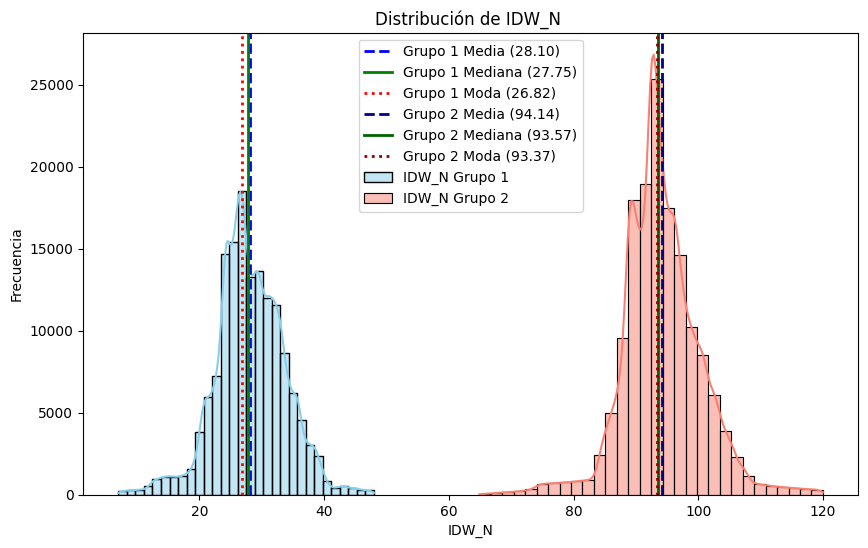


--- Variable Bimodal: IDW_P ---
  Grupo 1:
    Rango: 2.0010 → 16.9987
    Media: 9.8570, Mediana: 9.6749, Moda: 9.2499
    Curtosis: 0.8834, Asimetría: -0.0825
  Grupo 2:
    Rango: 23.3643 → 42.9989
    Media: 33.3825, Mediana: 33.1695, Moda: 32.8544
    Curtosis: 2.7188, Asimetría: 0.3030


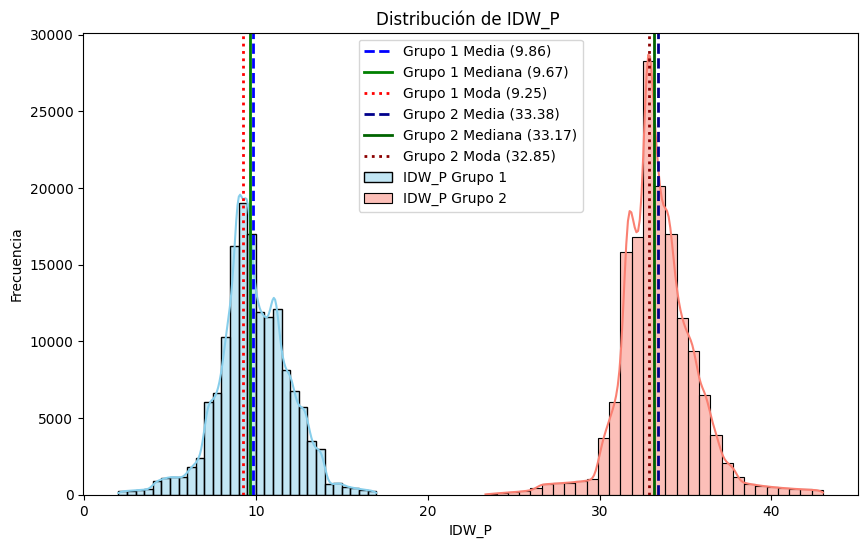


--- Variable Bimodal: IDW_K ---
  Grupo 1:
    Rango: 3.0014 → 23.9980
    Media: 13.8993, Mediana: 13.7221, Moda: 13.1498
    Curtosis: 0.9939, Asimetría: -0.0754
  Grupo 2:
    Rango: 32.4309 → 59.9986
    Media: 47.0250, Mediana: 46.7172, Moda: 46.6742
    Curtosis: 2.2217, Asimetría: 0.1707


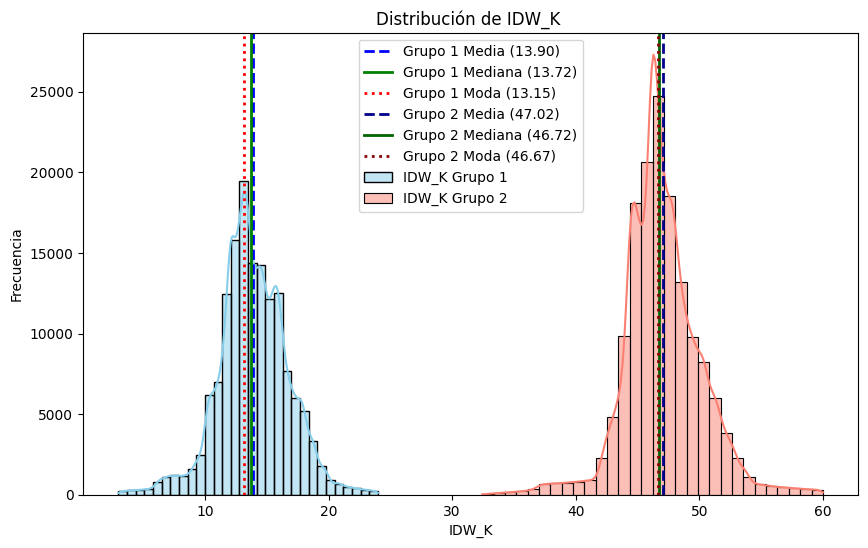


--- Variable Unimodal: NDVI ---
    Media: 0.2059, Mediana: 0.2109, Moda: 0.2152
    Curtosis: -0.4266, Asimetría: -0.1376


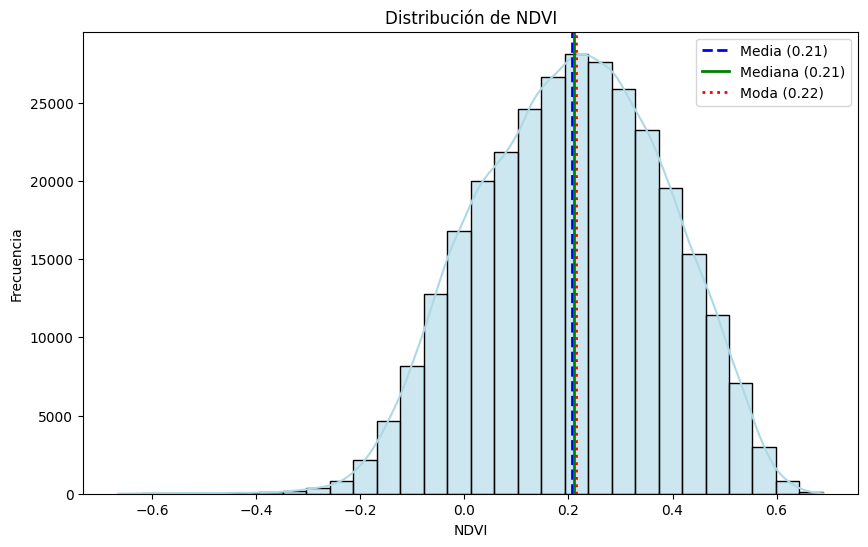


--- Variable Unimodal: Distancia_norm ---
    Media: 0.2438, Mediana: 0.2065, Moda: 0.1167
    Curtosis: 2.2449, Asimetría: 1.3025


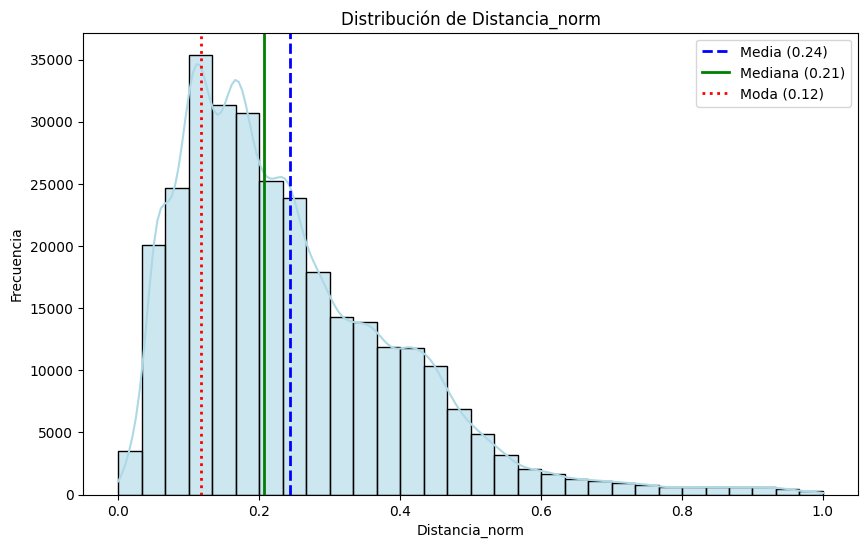

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Moda

def approximate_mode(data, bins=30):
    counts, bin_edges = np.histogram(data, bins=bins)
    max_bin_index = np.argmax(counts)
    mode_val = (bin_edges[max_bin_index] + bin_edges[max_bin_index+1]) / 2
    return mode_val

#Detecta los saltos para las graficas con dos modas
def split_by_gap(data, gap_threshold=None):
    sorted_data = np.sort(data)
    diffs = np.diff(sorted_data)

    if gap_threshold is None:
        gap_threshold = 5 * np.median(diffs)

    gap_index = np.where(diffs > gap_threshold)[0]
    if len(gap_index) == 0:
        return [data]  # no hay cortes


    cut = gap_index[np.argmax(diffs[gap_index])]
    group1 = sorted_data[:cut+1]
    group2 = sorted_data[cut+1:]
    return [group1, group2]

# Calcular estadísticas
def calculate_stats(data):
    mean_val = np.mean(data)
    median_val = np.median(data)
    mode_val = approximate_mode(data)  # moda aproximada
    kurt = stats.kurtosis(data)
    skew = stats.skew(data)
    return mean_val, median_val, mode_val, kurt, skew

# Graficar
def plot_bimodal_distribution(groups, var_name, stats_list):
    plt.figure(figsize=(10, 6))

    # colores de relleno
    fill_colors = ["skyblue", "salmon"]

    # colores para líneas (media, mediana, moda)
    line_colors = [
        {"mean": "blue", "median": "green", "mode": "red"},
        {"mean": "darkblue", "median": "darkgreen", "mode": "darkred"}
    ]

    for i, (group, stats_dict) in enumerate(zip(groups, stats_list)):
        sns.histplot(group, bins=30, kde=True, color=fill_colors[i], alpha=0.5,
                     label=f'{var_name} Grupo {i+1}')

        # Líneas estadísticas diferenciadas
        plt.axvline(stats_dict["mean"], color=line_colors[i]["mean"], linestyle='--', linewidth=2,
                    label=f'Grupo {i+1} Media ({stats_dict["mean"]:.2f})')
        plt.axvline(stats_dict["median"], color=line_colors[i]["median"], linestyle='-', linewidth=2,
                    label=f'Grupo {i+1} Mediana ({stats_dict["median"]:.2f})')
        plt.axvline(stats_dict["mode"], color=line_colors[i]["mode"], linestyle=':', linewidth=2,
                    label=f'Grupo {i+1} Moda ({stats_dict["mode"]:.2f})')

    plt.title(f'Distribución de {var_name} ')
    plt.xlabel(var_name)
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.show()

# Variables
bimodal_vars = ['IDW_N', 'IDW_P', 'IDW_K']
unimodal_vars = ['NDVI', 'Distancia_norm']

# Análisis
for var in bimodal_vars:
    data = df[var].dropna().values
    print(f"\n--- Variable Bimodal: {var} ---")
    groups = split_by_gap(data)

    stats_list = []
    for i, group in enumerate(groups, 1):
        mean_val, median_val, mode_val, kurt, skew = calculate_stats(group)
        print(f"  Grupo {i}:")
        print(f"    Rango: {group.min():.4f} → {group.max():.4f}")
        print(f"    Media: {mean_val:.4f}, Mediana: {median_val:.4f}, Moda: {mode_val:.4f}")
        print(f"    Curtosis: {kurt:.4f}, Asimetría: {skew:.4f}")

        stats_list.append({"mean": mean_val, "median": median_val, "mode": mode_val})

    if len(groups) == 2:
        plot_bimodal_distribution(groups, var, stats_list)
    else:
        print(" No se detectaron dos grupos claros, se grafica como unimodal.")

# Unimodales
for var in unimodal_vars:
    data = df[var].dropna().values
    print(f"\n--- Variable Unimodal: {var} ---")
    if len(data) > 0:
        mean_val, median_val, mode_val, kurt, skew = calculate_stats(data)
        print(f"    Media: {mean_val:.4f}, Mediana: {median_val:.4f}, Moda: {mode_val:.4f}")
        print(f"    Curtosis: {kurt:.4f}, Asimetría: {skew:.4f}")

        plt.figure(figsize=(10, 6))
        sns.histplot(data, bins=30, kde=True, color="lightblue", alpha=0.6)
        plt.axvline(mean_val, color='blue', linestyle='--', linewidth=2, label=f'Media ({mean_val:.2f})')
        plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Mediana ({median_val:.2f})')
        plt.axvline(mode_val, color='red', linestyle=':', linewidth=2, label=f'Moda ({mode_val:.2f})')
        plt.title(f'Distribución de {var}')
        plt.xlabel(var)
        plt.ylabel("Frecuencia")
        plt.legend()
        plt.show()

### 1.7 Boxplots
Resaltan mediana, rango intercuartílico y posibles outliers.

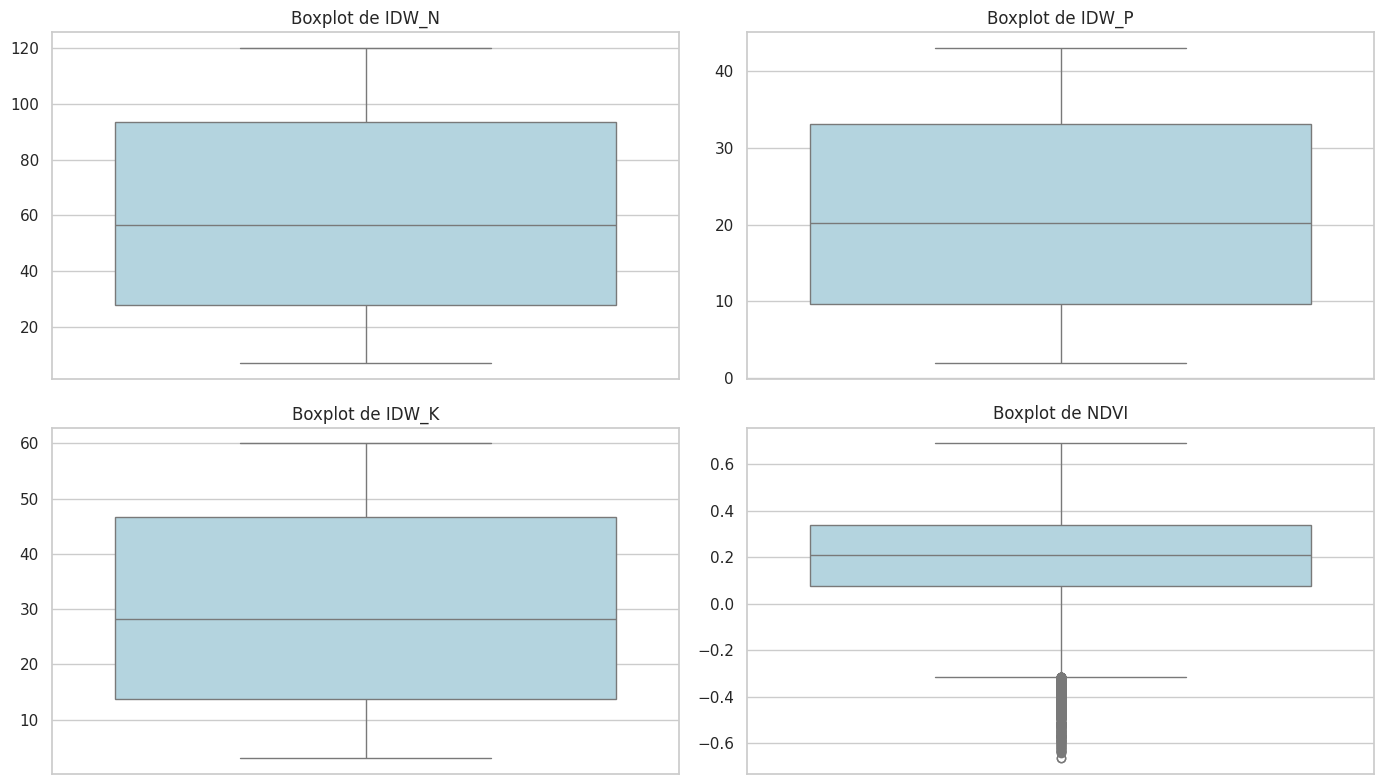

In [ ]:
#Graficos de bigote
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo de visualización
sns.set(style="whitegrid")

# Crear figura con 2 filas y 2 columnas
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

axs = axs.flatten()

variables = ['IDW_N', 'IDW_P', 'IDW_K', 'NDVI']
for i, col in enumerate(variables):
    sns.boxplot(y=df[col], ax=axs[i], color='lightblue')
    axs[i].set_title(f'Boxplot de {col}')
    axs[i].set_ylabel('')

plt.tight_layout()
plt.show()


###1.8) Diagramas de dispersión
Para estudiar la relación entre las variables predictoras y la variable de interes.


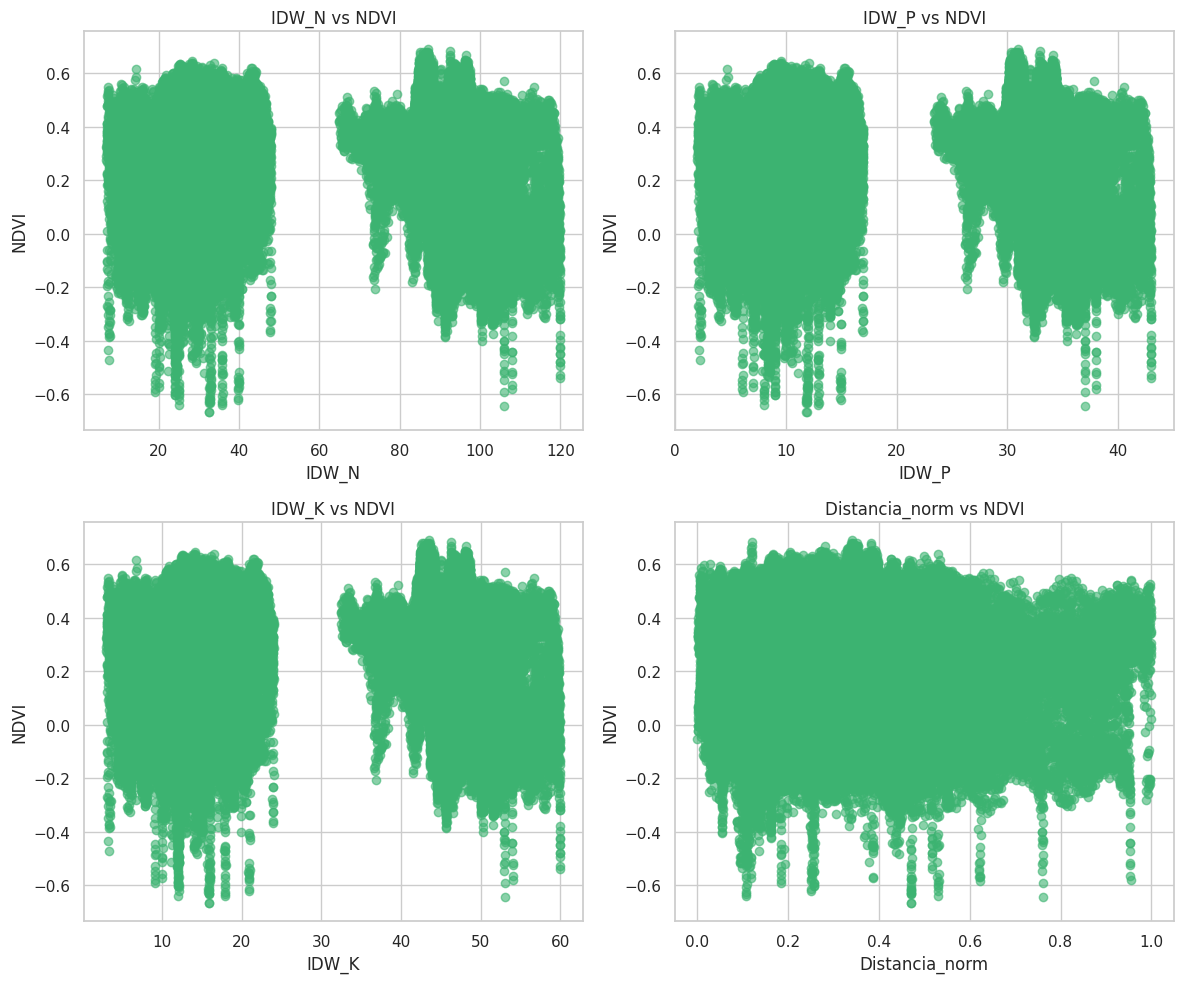

In [ ]:
#Diagramas de dispersión
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Variables de nutrientes vs NDVI
nutrientes = ['IDW_N', 'IDW_P', 'IDW_K', 'Distancia_norm']

axs = axs.flatten()

for i, nutriente in enumerate(nutrientes):
    axs[i].scatter(df[nutriente], df['NDVI'], alpha=0.6, color='mediumseagreen')
    axs[i].set_xlabel(nutriente)
    axs[i].set_ylabel('NDVI')
    axs[i].set_title(f'{nutriente} vs NDVI')

plt.tight_layout()
plt.show()

##Filtrado de datos atípicos

### 1.9 Eliminación de outliers (Puntaje Z)
Se filtran observaciones con `|Z| > umbral`

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301374 entries, 0 to 301373
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   x_pixel           301374 non-null  float64
 1   y_pixel           301374 non-null  float64
 2   IDW_N             301374 non-null  float64
 3   IDW_P             301374 non-null  float64
 4   IDW_K             301374 non-null  float64
 5   NDVI              301374 non-null  float64
 6   Latitud           301374 non-null  float64
 7   Longitud          301374 non-null  float64
 8   lat_norm          301374 non-null  float64
 9   lon_norm          301374 non-null  float64
 10  Distancia_norm    301374 non-null  float64
 11  Distancia_metros  301374 non-null  float64
dtypes: float64(12)
memory usage: 27.6 MB
None
Cantidad de outliers: 5153
<class 'pandas.core.frame.DataFrame'>
Index: 296221 entries, 0 to 301373
Data columns (total 12 columns):
 #   Column            Non-Null Count

array([[<Axes: title={'center': 'IDW_N'}>,
        <Axes: title={'center': 'IDW_P'}>],
       [<Axes: title={'center': 'IDW_K'}>,
        <Axes: title={'center': 'NDVI'}>],
       [<Axes: title={'center': 'Distancia_norm'}>, <Axes: >]],
      dtype=object)

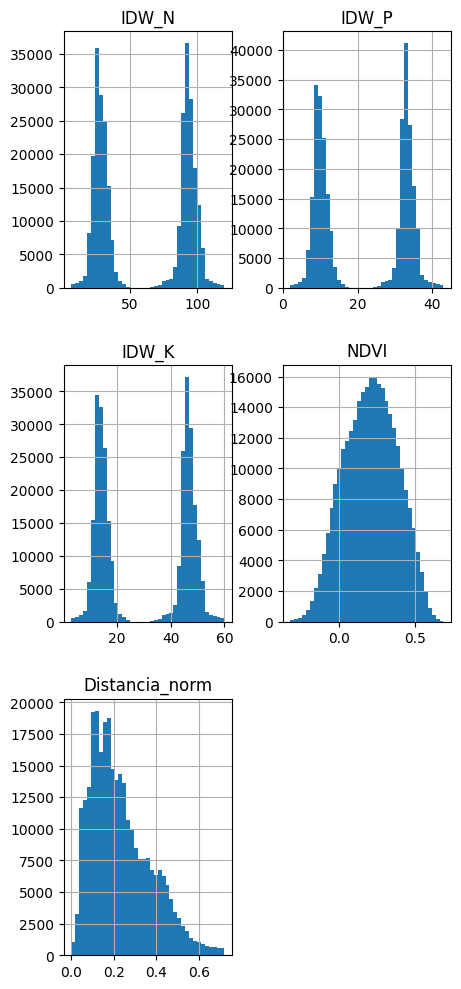

In [9]:
#Outliers con puntaje z
print(df.info())
z_scores = np.abs(stats.zscore(df[['IDW_N','IDW_P','IDW_K','NDVI','Distancia_norm']]))
outliers = (z_scores > 3).any(axis=1)
print("Cantidad de outliers:", outliers.sum())
df_z = df[~outliers]
df_z.info()
print("La cantidad es:",df_z.shape)
df_z[['IDW_N','IDW_P','IDW_K','NDVI','Distancia_norm']].hist(bins=39, figsize=(5,12))

### 1.10 Eliminación de outliers (Tukey / IQR)
Se eliminan observaciones fuera de `[Q1 - 1.5·IQR, Q3 + 1.5·IQR]`.


Columna: IDW_N
IQR: 65.8196, Límite inferior: -70.9835, Límite superior: 192.2951
Número de outliers detectados: 0

Columna: IDW_P
IQR: 23.4946, Límite inferior: -25.5669, Límite superior: 68.4114
Número de outliers detectados: 0

Columna: IDW_K
IQR: 32.9951, Límite inferior: -35.7706, Límite superior: 96.2098
Número de outliers detectados: 0

Columna: NDVI
IQR: 0.2609, Límite inferior: -0.3148, Límite superior: 0.7288
Número de outliers detectados: 454

Columna: Distancia_norm
IQR: 0.2067, Límite inferior: -0.1857, Límite superior: 0.6409
Número de outliers detectados: 7487

Tamaño original: (301374, 12)
Tamaño sin outliers: (293458, 12)


array([[<Axes: title={'center': 'IDW_N'}>,
        <Axes: title={'center': 'IDW_P'}>],
       [<Axes: title={'center': 'IDW_K'}>,
        <Axes: title={'center': 'NDVI'}>],
       [<Axes: title={'center': 'Distancia_norm'}>, <Axes: >]],
      dtype=object)

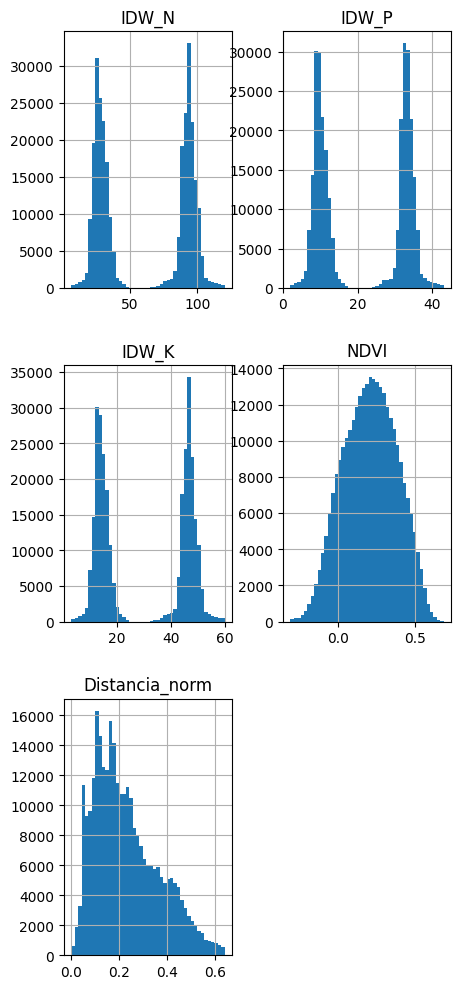

In [18]:
#Outliers con Tuckey
# Seleccionamos las columnas numéricas en las que queremos aplicar Tukey
variables = ['IDW_N', 'IDW_P', 'IDW_K', 'NDVI','Distancia_norm']

# Función para eliminar outliers usando el método de Tukey
def eliminar_outliers_tukey(df, columnas):
    df_limpio = df.copy()
    for col in columnas:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        print(f"\nColumna: {col}")
        print(f"IQR: {IQR:.4f}, Límite inferior: {limite_inferior:.4f}, Límite superior: {limite_superior:.4f}")
        outliers = df[(df[col] < limite_inferior) | (df[col] > limite_superior)]
        print(f"Número de outliers detectados: {outliers.shape[0]}")
        df_limpio = df_limpio[(df_limpio[col] >= limite_inferior) & (df_limpio[col] <= limite_superior)]
    return df_limpio

# Aplicar la función
df_sin_outliers = eliminar_outliers_tukey(df, variables)

# Mostrar forma final del DataFrame
print("\nTamaño original:", df.shape)
print("Tamaño sin outliers:", df_sin_outliers.shape)
df_sin_outliers[['IDW_N','IDW_P','IDW_K','NDVI','Distancia_norm']].hist(bins=45, figsize=(5,12))

In [11]:
#Comparar tamaños de dataset con y sin outliers
print("Tamaño original:", df.shape)
print("Tamaño sin outliers (z-score):", df_z.shape)
print("Tamaño sin outliers (Tukey):", df_sin_outliers.shape)

Tamaño original: (301374, 12)
Tamaño sin outliers (z-score): (296221, 12)
Tamaño sin outliers (Tukey): (300920, 12)


##2) Entrenamiento de modelos computacionales

### 2.1 Modelos con datos originales
Punto de referencia sin eliminación de outliers.

In [7]:
#Entrenamientos datos originales
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#CON LOS DATOS CRUDOS
# Seleccionar características y etiqueta
X = df[['IDW_N', 'IDW_P', 'IDW_K', 'Distancia_norm']]
y = df['NDVI']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Definir modelos con configuraciones
modelos = {
    "Linear Regression": pipeline_lr,
    "Random Forest": RandomForestRegressor( random_state=42),
    "KNN (5 vecinos)": KNeighborsRegressor(n_neighbors=5),
    "XGBoost (profundidad 10)": xgb.XGBRegressor( objective="reg:squarederror",n_estimators=50, max_depth=10, random_state=42, verbosity=0),
}

# Evaluación
resultados = []

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    resultados.append({
        "Modelo": nombre,
        "R2": r2,
        "RMSE": rmse,
        "MAE": mae
    })

# Mostrar resultados
resultados_df = pd.DataFrame(resultados).sort_values(by="R2", ascending=False)
print(resultados_df)

                     Modelo        R2      RMSE       MAE
1             Random Forest  0.721841  0.093764  0.065009
3  XGBoost (profundidad 10)  0.615439  0.110248  0.082588
2           KNN (5 vecinos)  0.605397  0.111678  0.080871
0         Linear Regression  0.035808  0.174570  0.141968


### 2.1.1 Evaluación de variables y sus pesos en los datos
Se puede estudiar las posibles variables con mas peso dentro del modelamiento, en este caso con ayuda del modelo XGBoost.

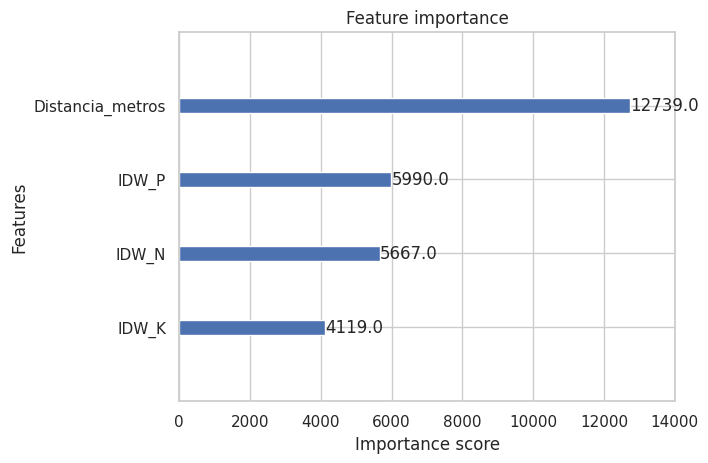

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(modelos["XGBoost (profundidad 10)"])
plt.show()

###2.2 Entrenamiento de modelos con datos sin datos atípicos por medio de puntaje z.

In [ ]:

#Entrenamiento con datos sin outliers (Puntaje Z)
# Seleccionar características y etiqueta de df_z

X_z = df_z[['IDW_N', 'IDW_P', 'IDW_K', 'Distancia_norm']]
y_z = df_z['NDVI']

# Dividir en entrenamiento y prueba para df_z
X_train_z, X_test_z, y_train_z, y_test_z = train_test_split(X_z, y_z, test_size=0.2, random_state=42)

# Definir modeloses
modelos_z = {
    "Linear Regression (Z)": LinearRegression(),
    "Random Forest (Z)": RandomForestRegressor(random_state=42),
    "KNN (5 vecinos) (Z)": KNeighborsRegressor(n_neighbors=5),
    "XGBoost (profundidad 10) (Z)": xgb.XGBRegressor(n_estimators=50, max_depth=10, random_state=42, verbosity=0),
}

# Evaluación con df_z
resultados_z = []

for nombre, modelo in modelos_z.items():
    modelo.fit(X_train_z, y_train_z)
    y_pred_z = modelo.predict(X_test_z)

    r2_z = r2_score(y_test_z, y_pred_z)
    mse_z = mean_squared_error(y_test_z, y_pred_z)
    rmse_z = np.sqrt(mse_z)
    mae_z = mean_absolute_error(y_test_z, y_pred_z)

    resultados_z.append({
        "Modelo": nombre,
        "R2": r2_z,
        "RMSE": rmse_z,
        "MAE": mae_z
    })

# Mostrar resultados para df_z
resultados_df_z = pd.DataFrame(resultados_z).sort_values(by="R2", ascending=False)
print("\nResultados con datos sin Outliers (Puntaje Z):")
resultados_df_z


Resultados con datos sin Outliers (Puntaje Z):


,Modelo,R2,RMSE,MAE
1,Random Forest (Z),0.731839,0.090984,0.063476
3,XGBoost (profundidad 10) (Z),0.613740,0.109196,0.082495
2,KNN (5 vecinos) (Z),0.612032,0.109437,0.079801
0,Linear Regression (Z),0.041505,0.172013,0.140169


In [ ]:
#Esta sección es usada para exportar el modelo a usar.
import joblib
import os

# seleccionar el modelo
random_forest_z_model = modelos_z["Random Forest (Z)"]

# Definir el nombre del modelo a exportar
model_filename = 'random_forest_z_outliers_model.joblib'

joblib.dump(random_forest_z_model, model_filename)

print(f"Random Forest model (Z-score outlier removed) exported successfully to '{model_filename}'")
if os.path.exists(model_filename):
    print(f"File '{model_filename}' created.")
else:
    print(f"Error: File '{model_filename}' was not created.")

Random Forest model (Z-score outlier removed) exported successfully to 'random_forest_z_outliers_model.joblib'
File 'random_forest_z_outliers_model.joblib' created.


###2.3 Entrenamiento de modelos con datos sin datos atípicos por medio de Tuckey.

In [19]:

#Datos sin outliers por método de Tuckey.
# Seleccionar características y etiqueta de df_sin_outliers
X_tukey = df_sin_outliers[['IDW_N', 'IDW_P', 'IDW_K', 'Distancia_norm']]
y_tukey = df_sin_outliers['NDVI']

# Dividir en entrenamiento y prueba para df_sin_outliers
X_train_tukey, X_test_tukey, y_train_tukey, y_test_tukey = train_test_split(X_tukey, y_tukey, test_size=0.2, random_state=42)

#Escalar los datos de entrada
scaler = MinMaxScaler()
X_train_tukey_scaled = scaler.fit_transform(X_train_tukey)
X_test_tukey_scaled = scaler.transform(X_test_tukey)

# Definir modelos
modelos_tukey = {
    "Linear Regression (Tukey)": LinearRegression(),
    "Random Forest (Tukey)": RandomForestRegressor(random_state=42),
    "KNN (5 vecinos) (Tukey)": KNeighborsRegressor(n_neighbors=5),
    "XGBoost (profundidad 10) (Tukey)": xgb.XGBRegressor(n_estimators=50, max_depth=10, random_state=42, verbosity=0),
}

# Evaluación con df_sin_outliers
resultados_tukey = []

for nombre, modelo in modelos_tukey.items():
    # Entrenar con los datos escalados
    modelo.fit(X_train_tukey_scaled, y_train_tukey)
    # Predecir con los datos escalados
    y_pred_tukey = modelo.predict(X_test_tukey_scaled)

    r2_tukey = r2_score(y_test_tukey, y_pred_tukey)
    mse_tukey = mean_squared_error(y_test_tukey, y_pred_tukey)
    rmse_tukey = np.sqrt(mse_tukey)
    mae_tukey = mean_absolute_error(y_test_tukey, y_pred_tukey)

    resultados_tukey.append({
        "Modelo": nombre,
        "R2": r2_tukey,
        "RMSE": rmse_tukey,
        "MAE": mae_tukey
    })

# Mostrar resultados para df_sin_outliers
resultados_df_tukey = pd.DataFrame(resultados_tukey).sort_values(by="R2", ascending=False)
print("\nResultados con datos sin Outliers (Tukey):")
resultados_df_tukey


Resultados con datos sin Outliers (Tukey):


,Modelo,R2,RMSE,MAE
1,Random Forest (Tukey),0.733494,0.090428,0.063231
2,KNN (5 vecinos) (Tukey),0.662274,0.101796,0.070906
3,XGBoost (profundidad 10) (Tukey),0.615859,0.108567,0.081892
0,Linear Regression (Tukey),0.044043,0.171265,0.139643


###2.4 Redes neuronales
Entrenamiento con perceptrón multicapa u otras arquitecturas empleadas en el proyecto.

In [ ]:
#Redes neuronales
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop


# cargar datos
df = pd.read_excel("dataset_combinado.xlsx").dropna()

X = df[['IDW_N', 'IDW_P', 'IDW_K', 'Distancia_norm']]
y = df['NDVI']

# Escalado
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


# Definición de modelos de dl
configs = {
    "profundo_denso": lambda: Sequential([
        Dense(128, input_dim=4, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ]),

    "dropout_batchnorm": lambda: Sequential([
        Dense(64, input_dim=4, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='linear')
    ]),

    "activacion_tanh": lambda: Sequential([
        Dense(64, input_dim=4, activation='tanh'),
        Dense(32, activation='tanh'),
        Dense(1, activation='linear')
    ]),

    "optimizador_rmsprop": lambda: Sequential([
        Dense(64, input_dim=4, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
}

# Optimizadores
optimizers = {
    "profundo_denso": Adam(learning_rate=0.001),
    "dropout_batchnorm": Adam(learning_rate=0.001),
    "activacion_tanh": Adam(learning_rate=0.001),
    "optimizador_rmsprop": RMSprop(learning_rate=0.001)
}

# Entrenamiento
results = {}

for name, build_model in configs.items():
    tf.keras.backend.clear_session()

    model = build_model()
    model.compile(optimizer=optimizers[name], loss='mse', metrics=['mae'])

    early_stop = EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=16,
        verbose=1,
        callbacks=[early_stop]
    )

    # Predicciones
    y_pred = model.predict(X_test).flatten()

    # Métricas
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "R2": r2}


#Resultados:
    print(f"\nModelo: {name}")
    print(f"MAE: {metrics['MAE']:.4f}")
    print(f"R² : {metrics['R2']:.4f}")


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12055/12055 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 0.0299 - mae: 0.1395 - val_loss: 0.0271 - val_mae: 0.1328
Epoch 2/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 0.0272 - mae: 0.1330 - val_loss: 0.0255 - val_mae: 0.1288
Epoch 3/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 0.0256 - mae: 0.1283 - val_loss: 0.0242 - val_mae: 0.1238
Epoch 4/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.0246 - mae: 0.1251 - val_loss: 0.0233 - val_mae: 0.1209
Epoch 5/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.0239 - mae: 0.1231 - val_loss: 0.0228 - val_mae: 0.1203
Epoch 6/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 0.0235 - mae: 0.1216 - val_loss: 0.0221 - val_mae: 0.1177
Epoch 7/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.0233 - mae: 0.1211 - val_loss: 0.0232 - val_mae: 0.1208
Epoch 8/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.0232 - mae: 0.1204 - val_loss: 0.0228 - val_mae: 0.1194
Epoch 9/50
12055/12055 ━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12055/12055 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 0.0499 - mae: 0.1650 - val_loss: 0.0292 - val_mae: 0.1394
Epoch 2/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 0.0297 - mae: 0.1395 - val_loss: 0.0284 - val_mae: 0.1364
Epoch 3/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 0.0293 - mae: 0.1385 - val_loss: 0.0284 - val_mae: 0.1366
Epoch 4/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 0.0293 - mae: 0.1388 - val_loss: 0.0283 - val_mae: 0.1358
Epoch 5/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.0290 - mae: 0.1379 - val_loss: 0.0279 - val_mae: 0.1356
Epoch 6/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.0290 - mae: 0.1379 - val_loss: 0.0284 - val_mae: 0.1364
Epoch 7/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - loss: 0.0289 - mae: 0.1376 - val_loss: 0.0281 - val_mae: 0.1360
Epoch 8/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 0.0291 - mae: 0.1381 - val_loss: 0.0285 - val_mae: 0.1357
Epoch 9/50
12055/12055 ━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12055/12055 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 0.0313 - mae: 0.1430 - val_loss: 0.0293 - val_mae: 0.1377
Epoch 2/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.0295 - mae: 0.1387 - val_loss: 0.0297 - val_mae: 0.1374
Epoch 3/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.0284 - mae: 0.1355 - val_loss: 0.0283 - val_mae: 0.1345
Epoch 4/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.0285 - mae: 0.1357 - val_loss: 0.0281 - val_mae: 0.1343
Epoch 5/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.0283 - mae: 0.1350 - val_loss: 0.0279 - val_mae: 0.1337
Epoch 6/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.0280 - mae: 0.1342 - val_loss: 0.0276 - val_mae: 0.1336
Epoch 7/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.0279 - mae: 0.1342 - val_loss: 0.0275 - val_mae: 0.1338
Epoch 8/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.0277 - mae: 0.1338 - val_loss: 0.0274 - val_mae: 0.1335
Epoch 9/50
12055/12055 ━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12055/12055 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.0299 - mae: 0.1398 - val_loss: 0.0280 - val_mae: 0.1345
Epoch 2/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.0281 - mae: 0.1350 - val_loss: 0.0271 - val_mae: 0.1325
Epoch 3/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 0.0273 - mae: 0.1331 - val_loss: 0.0282 - val_mae: 0.1342
Epoch 4/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.0267 - mae: 0.1315 - val_loss: 0.0266 - val_mae: 0.1318
Epoch 5/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.0263 - mae: 0.1303 - val_loss: 0.0261 - val_mae: 0.1313
Epoch 6/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.0256 - mae: 0.1286 - val_loss: 0.0251 - val_mae: 0.1254
Epoch 7/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.0253 - mae: 0.1276 - val_loss: 0.0247 - val_mae: 0.1259
Epoch 8/50
12055/12055 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.0251 - mae: 0.1269 - val_loss: 0.0243 - val_mae: 0.1243
Epoch 9/50
12055/12055 ━━━━

In [ ]:
#Modelo adicional
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 1. Cargar y preparar los datos
x=df_sin_outliers[['IDW_N', 'IDW_P', 'IDW_K', 'Distancia_norm']]
y = df_sin_outliers['NDVI']

# 3. Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 4. Crear el modelo
model = Sequential()
model.add(Dense(64, input_dim=4, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

# 5. Compilar
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 6. Entrenar
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=75, batch_size=16, callbacks=[early_stop], verbose=1)

# 7. Evaluar
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"R² Score: {r2}")

# 8. Graficar resultados
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("NDVI Real")
plt.ylabel("NDVI Predicho")
plt.title("Red Neuronal - Comparación NDVI")
plt.grid(True)
plt.show()

'import pandas as pd\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import MinMaxScaler\nfrom sklearn.metrics import mean_absolute_error, r2_score\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense, Dropout\nfrom tensorflow.keras.callbacks import EarlyStopping\nimport matplotlib.pyplot as plt\n\n# 1. Cargar y preparar los datos\nx=df_sin_outliers[[\'IDW_N\', \'IDW_P\', \'IDW_K\', \'Distancia_norm\']]\ny = df_sin_outliers[\'NDVI\']\n\n# 3. Dividir los datos\nX_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)\n\n# 4. Crear el modelo\nmodel = Sequential()\nmodel.add(Dense(64, input_dim=4, activation=\'relu\'))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(32, activation=\'relu\'))\nmodel.add(Dense(16, activation=\'relu\'))\nmodel.add(Dense(1, activation=\'linear\'))\n\n# 5. Compilar\nmodel.compile(optimizer=\'adam\', loss=\'mse\', metrics=[\'mae\'])\n\n# 6. Entrenar\nearly_stop = 